# Get training data (w/search) and train model

Good training data is hard to come by. We are apporximating it by using observations with a high search-score.

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
import time
import datetime
from bs4 import BeautifulSoup
from elasticsearch import Elasticsearch
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils
import html
import re
import os
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
import pickle
import sqlalchemy
import pandas as pd
from sqlalchemy import create_engine
from keras.models import load_model

Using TensorFlow backend.


In [2]:
file_path = '/home/radbrt/notebooks/hackathon/processed/processed/'

In [3]:
files = [file for file in os.listdir(file_path) if file.startswith('jobb')]

In [4]:
stops = set(stopwords.words("norwegian"))

def alphanum(text):
    return re.sub("[^A-Za-zæÆøØåÅ]", " ", text)

def remove_stops(text):
    return " ".join([word for word in text.split() if word not in stops])

def clean_text(text):
    cleantext = text.lower()
    cleantext = alphanum(cleantext)
    cleantext = remove_stops(cleantext)
    return cleantext

In [5]:
%run ../connect_elastic.py

In [6]:
def essearch(name):
    try:
        return es.search(index='yrkeskoder', body={"query": {"multi_match": {"query": name, "fields": ["tittel_98"]}}})
    except:
        return {}

In [7]:
docs = []

In [8]:
import sys
for file in files:
    try:
        e = {}
        f = open(file_path + file, 'r').read()
        funescape = html.unescape(f)
        soup = BeautifulSoup(funescape, 'html.parser')
        stillingsinfo = soup.find_all('section', 'stillingsinfo')
        e['file'] = file
        e['tittel'] = stillingsinfo[0].find_all('h1', attrs={'id': 'tittelvalue'})[0].get_text()
        e['text'] = stillingsinfo[0].find_all('p')[0].get_text()
        r = essearch(e['tittel'])
        e['score'] = r['hits']['hits'][0]['_score']
        e['isco08'] = r['hits']['hits'][0]['_source']['isco08']
        docs.append(e)
    except:
        sys.exc_info()[0]

In [9]:
len(docs)

10367

In [10]:
df = pd.DataFrame(docs)

In [11]:
df.to_csv('../traintest.csv', sep=';')

In [12]:
df.dtypes

file       object
isco08     object
score     float64
text       object
tittel     object
dtype: object

### Subset the best matches

Scores above 8:

In [13]:
len(df[(df['score']>8)])

4538

Scores above 10:

In [14]:
len(df[(df['score']>8)])

4538

Plot distribution:

In [15]:
import matplotlib.pyplot as plt

In [16]:
plot = plt.hist(df[(df['score']<15)]['score'], bins=30)

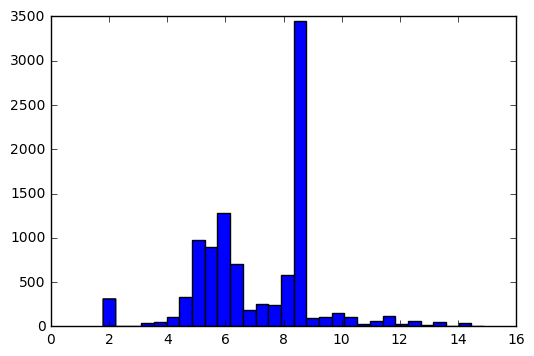

In [17]:
plt.show()

In [18]:
max(df['score'])

37.410915000000003

In [19]:
hs = df[(df['score']>=8.5)]

In [20]:
hs.head()

,file,isco08,score,text,tittel
0,jobb9616417.html,5321,8.524551,Helsefagarbeider Lønn: Etter gjeldene tariff S...,Helsefagarbeider
1,jobb9622590.html,5120,8.576396,Nesbyen Kro har ledig stilling som kokk/kro-me...,Kokk/kro-medarbeider
2,jobb9624738.html,8322,11.192215,Vi søker vikarer som kan jobbe en fast dag per...,"Budbil sjåfør, DHL Express - vikar"
4,jobb9609378.html,2223,8.580832,Beskrivelse av arbeidsstedVi har ledig 80-100%...,Sykepleier (ref.nr: 3299)
5,jobb9613706.html,4321,8.576396,www.byggspar.no Hei :) Vi ser etter en som kun...,Butikk- og lagermedarbeider med klasse C (last...


In [21]:
X = hs['text'].apply(clean_text)
y = hs['isco08']
print(y[0:3])

0    5321
1    5120
2    8322
Name: isco08, dtype: object


In [22]:
X.shape

(4270,)

In [23]:
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [24]:
labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)

num_classes = np.max(y_encoded) + 1
yhot = keras.utils.to_categorical(y_encoded, num_classes)

In [25]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X)
X_matrix = tokenizer.texts_to_matrix(X, mode='binary')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_matrix, yhot, train_size=0.8)
outputlayers = yhot.shape[1]

In [27]:
model = Sequential()
model.add(Dense(2048, input_shape = (5000,)))
model.add(Activation('relu'))
model.add(Dense(outputlayers))
model.add(Activation('softmax'))

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
history = model.fit(X_train, y_train,
                    batch_size=100,
                    epochs=120,
                    verbose=0)

## Check the score on the training data

In [30]:
score = model.evaluate(X_test, y_test,
                       batch_size=100, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

800/854 [===========================>..] - ETA: 0sTest score: 2.51579708796
Test accuracy: 0.639344267879


### Save model etc

In [31]:
import pickle
model.save('../model3.h5')

with open('../labelencoder3.pickle', 'wb') as handle:
    pickle.dump(labelencoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../tokenizr3.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)